In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts

In [2]:
# data taken from: https://www.formula1.com/en/results.html/2017/races/976/mexico/pit-stop-summary.html
tracks = ['AUS', 'MAL', 'CHI', 'TUR', 'ESP', 'MON', 'CAN', 'EUR', 'GBR', 'GER', 'HUN', 'BEL', 'ITA', 'SIN', 
          'JAP', 'ADH','BRA', 'USA', 'MEX', 'RUS', 'BAH', 'IMO', 'AZE', 'STY', 'FRA', 'NED']
times = [28, 22, 23, 17, 17, 21, 16, 21, 19, 18, 19, 18, 23, 30, 18, 20, 16, 24, 23, 25, 25, 30, 24, 21, 36, 19]
times_sf = [round(0.6 * time, 2) for time in times]
df = pd.DataFrame({'tracks': tracks, 'times': times, 'times_sf': times_sf})
df

,tracks,times,times_sf
0,AUS,28,16.8
1,MAL,22,13.2
2,CHI,23,13.8
3,TUR,17,10.2
4,ESP,17,10.2
5,MON,21,12.6
6,CAN,16,9.6
7,EUR,21,12.6
8,GBR,19,11.4
9,GER,18,10.8


In [3]:
cars = ['HAM', 'RUS', 'PER', 'VER', 'LEC', 'SAI', 'ALO', 'OCO', 'NOR', 'RIC', 'VET', 'STR', 'MSC', 'MAG', 
          'GAS', 'TSU','ALB', 'LAT',  'BOT', 'ZHO']
teams = (['Mercedes']*2 + ['Red Bull']*2 + ['Ferrari']*2 + ['Alpine']*2 + ['Mclaren']*2 + ['AstonMartin']*2 + 
         ['Haas']*2 + ['AlphaTauri']*2 + ['Williams']*2 + ['AlphaRomeo']*2)
time = [0, 30.9, 33.9, 37, 39.5, 42.7, 49.5, 52, 53.1, 57.2, 59.8, 66, 69.2, 78.0, 81.2, 90.3, 95.6, 100.4, 108.9, 142.2]
race = pd.DataFrame({'driver': cars, 'time': time, 'teams': teams})
race

,driver,time,teams
0,HAM,0.0,Mercedes
1,RUS,30.9,Mercedes
2,PER,33.9,Red Bull
3,VER,37.0,Red Bull
4,LEC,39.5,Ferrari
5,SAI,42.7,Ferrari
6,ALO,49.5,Alpine
7,OCO,52.0,Alpine
8,NOR,53.1,Mclaren
9,RIC,57.2,Mclaren


In [4]:
def simulate_pit_stop(change):
    '''
    Returns:
        The stationary time during the pit stop
    
    Inputs:
        Change (int): The kind of change that you want to make. Pass 1 for tyre change, 2 for wing change
    '''
    if change == 1:
        time = sts.norm(loc = 2.5, scale = 0.4).rvs()
    elif change == 2:
        time = sts.norm(loc = 7, scale = 0.75).rvs()
    else:
        return 'Wrong input'
    return time

In [5]:
# test case
simulate_pit_stop(1)

2.430172454077634

In [6]:
# setting new times for the data frame
time = [0,17.54,18.69,20.0,15.4,21.2,23.4,28.3,48.6,32.2,37.5,40.2,44.7,50.2,51.2,56.8,59.8,70.4,49.2,53.2]
# defining the data frame
race = pd.DataFrame({'driver': cars, 'gap': time, 'team': teams})

def pit_track_confint(change, track, driver, safety_car = 0):
    '''
    Output:
        A function that returns the confidence intervals as well as the results from a probabilistic model
        
    Returns:
        A tuple of lists. The first list contains the two values for the 95% confidence interval. The second is
        the list of all the simulation results
        
    Input:
        change (int): the type of pit stop that we are making. This will be 1 if we are just changing tyres or 2
                      if the change also involves a front-wing change.
        
        track (str): the track that the race is happening on. This is important as pit lane timings are dependent on
                     the exact we are racing at.
        
        driver (str): the driver under consideration. This is important to keep track of track position.
        
        safety_car (int): Optional parameter. 
                          Default value: 0
                          If we are under safety car conditions, this can be set to 1 to simulate accordingly
    
    '''
    # list for storing results
    results = []
    # running a 1000 simulations
    for i in range(1000):
        # creating a new race based on initial conditions for each race
        race = pd.DataFrame({'driver': cars, 'gap': time})
        new_race = race
        # check for safety car conditions
        if safety_car == 0:
            # take values from corresponding columns
            track_time = float(df[df['tracks'] == track].times)
        else:
            track_time = float(df[df['tracks'] == track].times_sf)
        # add the stationary time to the track time
        total_time = track_time + simulate_pit_stop(change)
        # retrieve current gap from leader
        current_gap = float(new_race[new_race['driver'] == driver].gap)
        # calculate new gap relative to the initial leader
        new_time = current_gap + total_time
        # add the new gap to the list of results
        results.append(new_time)
    
    # calculate the confidence intervals for the simulation results
    confint = [np.mean(results) - (1.96*np.std(results)), np.mean(results) + (1.96*np.std(results))]
    return (confint, results)

race = pd.DataFrame({'driver': cars, 'gap': time, 'team': teams})
def pit_track(change, track, driver, safety_car = 0):
    '''
    Ouput:
        Prints the expected outcomes from a decision, plots the simulation results along with confidence intervals,
        and displays the new race conditions as a data frame.
        
    Input:
        change (int): the type of pit stop that we are making. This will be 1 if we are just changing tyres or 2
                      if the change also involves a front-wing change.
        
        track (str): the track that the race is happening on. This is important as pit lane timings are dependent on
                     the exact we are racing at.
        
        driver (str): the driver under consideration. This is important to keep track of track position.
        
        safety_car (int): Optional parameter. 
                          Default value: 0
                          If we are under safety car conditions, this can be set to 1 to simulate accordingly
    
    '''
    # display the current situation
    print('Current race standings')
    current_race = race
    current_race = current_race.sort_values('gap')
    current_race = current_race.reset_index()
    current_race['position'] = current_race.index + 1
    current_race = current_race.drop(columns = ['index'])
    display(current_race)
    
    # run the simulations and store the results in a variable
    confint = pit_track_confint(change, track, driver, safety_car = safety_car)
    
    # copy data frame to 3 different variables for easy manipulation
    new_race = race
    lower = race
    upper = race
    # calculate race position and store in a new column
    new_race['previous_position'] = race.index + 1
    lower['previous_position'] = race.index + 1
    upper['previous_position'] = race.index + 1
    # access the simulation results
    simulation_results = confint[1]
    # retrieve current gap to leader
    current_gap = float(new_race[new_race['driver'] == driver].gap)
    # calculate the expected gap to initial leader based on expected value
    new_time = current_gap + np.mean(simulation_results)
    # replace the old gap with the new one
    new_race.replace(to_replace = float(new_race[new_race['driver'] == driver].gap), value =  round(new_time, 2), inplace = True)
    # sort the data frames based on new gap values
    new_race = new_race.sort_values('gap')
    new_race = new_race.reset_index()
    # calculate new positions
    new_race['new_position'] = new_race.index + 1
    new_position = new_race[new_race['driver'] == driver].index[0] + 1
    old_position = int(new_race[new_race['driver'] == driver].previous_position)
    new_race = new_race.drop(columns = ['index'])
    print("On Average:")
    print('By Pitting, new position estimated will be: ', new_position, '\n' 'We lose: ', new_position - old_position, 'positions' '\n' 'Estimated time = ', round(new_time, 2))
    
    # set the gaps back to standard so that gap is now from the new leader and changed accordingly
    new_race['new_gap'] = new_race['gap']
    standard = new_race['new_gap'].iat[0]
    new_race['new_gap'] = new_race['new_gap'] - standard
    new_race = new_race.drop(columns = {'gap'})
    new_race = new_race[["driver", "team", "new_gap","previous_position","new_position"]]
    
    # repeat calculation for the lower bound of the 95% confidence interval
    possible_gap_lower = current_gap + confint[0][0]
    lower.replace(to_replace = float(lower[lower['driver'] == driver].gap), value =  round(possible_gap_lower, 2), inplace = True)
    lower = lower.sort_values('gap')
    lower = lower.reset_index()
    lower['new_position'] = lower.index + 1
    new_position_lower = lower[lower['driver'] == driver].index[0] + 1
    old_position_lower = int(lower[lower['driver'] == driver].previous_position)
    print('\n')
    print("Lower bound:")
    print('Lower bound of 95% confidence interval: ', new_position_lower, '\n' 'We lose: ', new_position_lower - old_position_lower, 'positions', '\n' 'New Estimated time = ', round(possible_gap_lower, 2))
   
    # repeat calculations for upper bound of 95% confidence interval
    possible_gap_upper = current_gap + confint[0][1]
    upper.replace(to_replace = float(upper[upper['driver'] == driver].gap), value =  round(possible_gap_upper, 2), inplace = True)
    upper = upper.sort_values('gap')
    upper = upper.reset_index()
    upper['new_position'] = upper.index + 1
    new_position_upper = upper[upper['driver'] == driver].index[0] + 1
    old_position_upper = int(upper[upper['driver'] == driver].previous_position)
    print('\n')
    print("Upper bound:")
    print('Upper bound of 95% confidence interval: ', new_position_upper, '\n' 'We lose: ', new_position_upper - old_position_upper, 'positions' '\n' 'New Estimated time = ', round(possible_gap_upper, 2))
    # plot the simulation results along with the 95% confidence interval
    plt.figure()
    plt.title('Simulation results')
    plt.xlabel('Expected time after pit stop')
    plt.ylabel('Probability')
    plt.hist([result + current_gap for result in simulation_results], bins = 25, edgecolor = 'white', density = True)
    plt.axvline(possible_gap_upper, color = 'yellow')
    plt.axvline(possible_gap_lower, color = 'yellow', label = '95% confidence intervals')
    plt.axvline(new_time, color = 'red', label = 'Expected value of results')
    plt.legend()
    plt.show()
    # display the new race conditions
    display(new_race)

### Confidence Intervals

Why do we calculate confidence intervals?

The reason for calculating the confidence intervals is that it gives us an insight into what we can expect to happen in our pit stops. As this is a probabilistic model, this is an important measure that should be done as we are not sure of what will happen. Thus, we use confidence intervals to get an idea into the best and worst-case scenarios of our simulation to estimate the possible risks & weigh them accordingly.

Current race standings


,driver,gap,team,position
0,HAM,0.00,Mercedes,1
1,LEC,15.40,Ferrari,2
2,RUS,17.54,Mercedes,3
3,PER,18.69,Red Bull,4
4,VER,20.00,Red Bull,5
5,SAI,21.20,Ferrari,6
6,ALO,23.40,Alpine,7
7,OCO,28.30,Alpine,8
8,RIC,32.20,Mclaren,9
9,VET,37.50,AstonMartin,10


On Average:
By Pitting, new position estimated will be:  6 
We lose:  5 positions
Estimated time =  21.52


Lower bound:
Lower bound of 95% confidence interval:  5 
We lose:  4 positions 
New Estimated time =  20.73


Upper bound:
Upper bound of 95% confidence interval:  6 
We lose:  5 positions
New Estimated time =  22.3


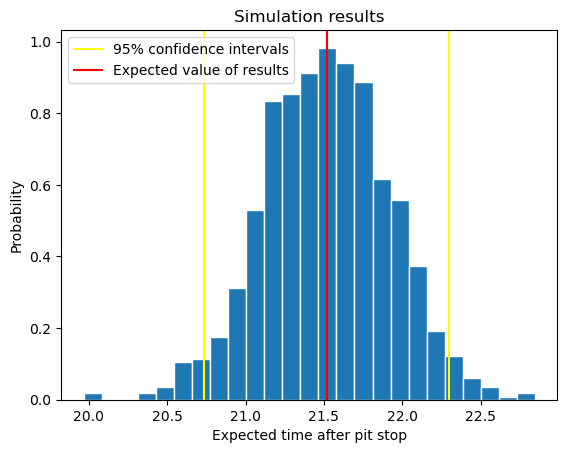

,driver,team,new_gap,previous_position,new_position
0,LEC,Ferrari,0.00,5,1
1,RUS,Mercedes,2.14,2,2
2,PER,Red Bull,3.29,3,3
3,VER,Red Bull,4.60,4,4
4,SAI,Ferrari,5.80,6,5
5,HAM,Mercedes,6.12,1,6
6,ALO,Alpine,8.00,7,7
7,OCO,Alpine,12.90,8,8
8,RIC,Mclaren,16.80,10,9
9,VET,AstonMartin,22.10,11,10


In [7]:
# Simulation to show difference between safety car conditions & normal racing conditions.
# There is no safety car in this and you'll see a large number of track positions are lost in this case
time = [0,17.54,18.69,20.0,15.4,21.2,23.4,28.3,48.6,32.2,37.5,40.2,44.7,50.2,51.2,56.8,59.8,70.4,49.2,53.2]
race = pd.DataFrame({'driver': cars, 'gap': time, 'team': teams})
race
pit_track(1, 'NED', 'HAM', safety_car = 0)

Current race standings


,driver,gap,team,position
0,HAM,0.00,Mercedes,1
1,LEC,15.40,Ferrari,2
2,RUS,17.54,Mercedes,3
3,PER,18.69,Red Bull,4
4,VER,20.00,Red Bull,5
5,SAI,21.20,Ferrari,6
6,ALO,23.40,Alpine,7
7,OCO,28.30,Alpine,8
8,RIC,32.20,Mclaren,9
9,VET,37.50,AstonMartin,10


On Average:
By Pitting, new position estimated will be:  1 
We lose:  0 positions
Estimated time =  13.9


Lower bound:
Lower bound of 95% confidence interval:  1 
We lose:  0 positions 
New Estimated time =  13.14


Upper bound:
Upper bound of 95% confidence interval:  1 
We lose:  0 positions
New Estimated time =  14.65


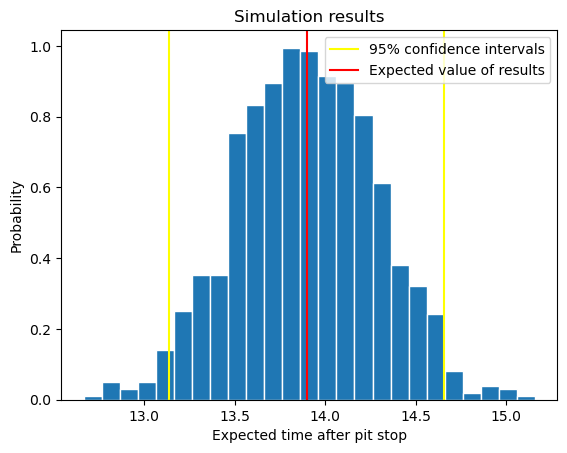

,driver,team,new_gap,previous_position,new_position
0,HAM,Mercedes,0.00,1,1
1,LEC,Ferrari,1.50,5,2
2,RUS,Mercedes,3.64,2,3
3,PER,Red Bull,4.79,3,4
4,VER,Red Bull,6.10,4,5
5,SAI,Ferrari,7.30,6,6
6,ALO,Alpine,9.50,7,7
7,OCO,Alpine,14.40,8,8
8,RIC,Mclaren,18.30,10,9
9,VET,AstonMartin,23.60,11,10


In [8]:
# simulation to show how safety car allows for a cheap stop. Notice the difference in the new conditions in both simulations
time = [0,17.54,18.69,20.0,15.4,21.2,23.4,28.3,48.6,32.2,37.5,40.2,44.7,50.2,51.2,56.8,59.8,70.4,49.2,53.2]
race = pd.DataFrame({'driver': cars, 'gap': time, 'team': teams})
race
pit_track(1, 'NED', 'HAM', safety_car = 1)